In [1]:
import re
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
from sklearn.linear_model import BayesianRidge, LinearRegression, Ridge
pd.set_option('display.max_rows', 500)

import warnings
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings('ignore')

In [2]:
DATA_PATH = "../output/vs_trains/*"
TRAIN_PATH = "../input/train.csv"
TEST_PATH = "../input/test.csv"
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
all_df = pd.concat([train,test], axis = 0, sort=True)
all_df = all_df.reset_index(drop=True)

In [3]:
all_df[all_df["アクセス"].str.contains('総武本線\t馬喰町駅\t徒歩4分\t\t都営浅草線\t浅草橋駅\t徒歩4分')].head(1)

,id,アクセス,キッチン,バス・トイレ,周辺環境,契約期間,室内設備,建物構造,所在地,所在階,放送・通信,方角,築年数,賃料,間取り,面積,駐車場
860,861,総武本線\t馬喰町駅\t徒歩4分\t\t都営浅草線\t浅草橋駅\t徒歩4分,ガスコンロ／\tコンロ3口／\tシステムキッチン,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...,NaN,NaN,冷房／\tエアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気...,RC（鉄筋コンクリート）,東京都中央区日本橋馬喰町２丁目,2階／12階建,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,南,0年3ヶ月,205000.0,1LDK,43.1m2,"駐車場\t空有\t43,200円\t駐輪場\t空有"


In [4]:
def built_floor_feature(df_input):
    df_out = pd.DataFrame()
    df_out["living_floor"] = df_input["所在階"].str.split('／', expand=True)[0].str.split("（", expand=True)[0].str.replace('[^0-9]', '').fillna(0)
    cnt = -1
    for i in df_out["living_floor"]:
        cnt += 1
        if len(str(i)) == 0:
            df_out["living_floor"][df_out["living_floor"].index[cnt]]=np.nan
            
    df_out["building_floor"] = df_input["所在階"].str.split('／', expand=True)[1].str.split("（", expand=True)[0].str.replace('[^0-9]', '').fillna(0)
    return df_out


def area_feature(df_input):
    df_out = pd.DataFrame()
    s = df_input["面積"]
    df_out["int面積"] = [int(float(i.split("m2")[0])) for i in s]
    return df_out


def element_count_feature(df_input):
    """要素数数え"""
    df_out = pd.DataFrame()
    #df_out["num_of_NULL"] = df_input.isnull().sum(axis=1)
    
    #df_out["周辺環境_element_counts"] = df_input["周辺環境"].str.count("【").fillna(0)
    df_out["室内設備_element_counts"] = df_input["室内設備"].str.count("\t").fillna(-1)+1
    df_out["バス・トイレ_element_counts"] = df_input["バス・トイレ"].str.count("\t").fillna(-1)+1
    df_out["キッチン_element_counts"] = df_input["キッチン"].str.count("\t").fillna(-1)+1
    df_out["放送・通信_element_counts"] = df_input["放送・通信"].str.count("\t").fillna(-1)+1
    
    #df_out["設備和"] = df_out[[col for col in df_out.columns if col != "num_of_NULL"]].sum(axis=1)
    
    #df_count = pd.concat([count_encoding(df_out, column) for column in df_out.columns], axis=1)
    #df_out = pd.concat([df_out,df_count], axis=1)
    return df_out

def direction_feature(df_input):
    """価格の高い順に値振り分け　南は高いらしい"""
    df_out = pd.DataFrame()
    direct_dict= {'南':8, '東':5, '西':4, '南東':7, '南西':6, '北':1, '北西':2, '北東':3}
    df_out["int方角"] = df_input["方角"].map(direct_dict)
    
    return df_out

def madori_feature(df_input):
    """間取りの数字部分と、アルファベット部分でそれぞれ特徴量化、納戸フラグ"""
    df_out = pd.DataFrame()
    s = df_input["間取り"]
    #df_out["int間取り"] = [int(re.sub('[^0-9]', "", i)) for i in s]
    #df_out["cat_int間取り"] = np.where(df_out["int間取り"] > 4, 5, df_out["int間取り"])
    #df_out["cat_int間取り"] = df_out["cat_int間取り"].astype(str)
    #df_out["納戸"] = [1 if "納戸" in i else 0 for i in s]
    madori_dict = {"R":1, "K":2, "DK":3, "LDK":4, "LK":4}
    #df_out["間取りtype"] = [re.sub('[0-9S(納戸)\+]', "", i) for i in s]
    #df_out["間取りtype"] = df_out["間取りtype"].map(madori_dict)
    
    #df_count = pd.concat([count_encoding(df_out, column) for column in df_out.columns if column not in ["納戸","cat_int間取り"]], axis=1)
    #df_out = pd.concat([df_out,df_count], axis=1)
    
    return df_out

def modify_rent(target, df_input):
    """ id == 5776 で賃料の0が一つ多い"""
    target = np.where(df_input["id"]==5776, 120350, target)
    
    return target

In [5]:
#all_df[["living_floor", "building_floor"]] = built_floor_feature(all_df)
tmp_df = pd.concat([built_floor_feature(all_df), element_count_feature(all_df),
                   madori_feature(all_df), direction_feature(all_df)], axis=1)
all_df["int面積"] = area_feature(all_df).values
all_df = pd.concat([all_df, tmp_df], axis=1)

In [6]:
#all_df["int面積1"] = area_feature(all_df).values
#all_df["int面積2"] = area_feature(all_df)
#(all_df["int面積1"] == all_df["int面積2"]).value_counts()
add_col = [col for col in list(tmp_df.columns) if col not in ["same_build", "living_floor", "int面積", "賃料", "id", "building_floor"]]
add_col

['室内設備_element_counts',
 'バス・トイレ_element_counts',
 'キッチン_element_counts',
 '放送・通信_element_counts',
 'int方角']

In [7]:
all_df["same_build"] = (all_df["building_floor"].astype(str) + all_df["アクセス"].astype(str))

In [8]:
all_df = all_df[["same_build", "living_floor", "int面積", "賃料", "id"] + add_col]
all_df.info()
all_df["賃料"] = all_df["賃料"].fillna(0)
all_df["living_floor"] = all_df["living_floor"].astype(float)
all_df = all_df.reset_index(drop=True)
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62732 entries, 0 to 62731
Data columns (total 10 columns):
same_build               62732 non-null object
living_floor             62499 non-null object
int面積                    62732 non-null int64
賃料                       31470 non-null float64
id                       62732 non-null int64
室内設備_element_counts      62732 non-null float64
バス・トイレ_element_counts    62732 non-null float64
キッチン_element_counts      62732 non-null float64
放送・通信_element_counts     62732 non-null float64
int方角                    57175 non-null float64
dtypes: float64(6), int64(2), object(2)
memory usage: 4.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62732 entries, 0 to 62731
Data columns (total 10 columns):
same_build               62732 non-null object
living_floor             62499 non-null float64
int面積                    62732 non-null int64
賃料                       62732 non-null float64
id                       62732 non-null int64
室内設備_elemen

In [9]:
train = all_df[all_df["賃料"]>0]
n_train = train.shape[0]
test = all_df[all_df["賃料"]==0]
train["予測値"] = 0

all_df["賃料"] = modify_rent(all_df["賃料"], all_df)

# bayesian ridge

In [10]:
duplicate_build_idx = all_df["same_build"].value_counts()>1
duplicate_keys = all_df["same_build"].value_counts()[duplicate_build_idx].keys()

result = []
method = []
aa = 0
for i in tqdm(range(len(duplicate_keys))):
    flag = 0
    tmp_df = all_df[all_df["same_build"]==str(duplicate_keys[i])]
    tmp_df["living_floor"] = tmp_df["living_floor"].fillna(tmp_df["living_floor"].mean())
    
    tmp_df["int方角"] = tmp_df["int方角"].fillna(tmp_df["int方角"].mean())
    tmp_df["int方角"] = tmp_df["int方角"].fillna(0)
    
    
    tr_df = tmp_df[tmp_df["賃料"]>0][["living_floor", "int面積", "賃料"] + add_col]
    
    use_col = [col for col in list(tr_df.columns) if col != "賃料"]
    
    minim = tr_df["int面積"].min()
    maxim = tr_df["int面積"].max()
    range_ = maxim - minim
    ts_df = tmp_df[tmp_df["賃料"]==0][use_col]      #[["living_floor","int面積"] + add_col]
    
    #ts_df = ts_df[ts_df["int面積"] >= minim][maxim >= ts_df["int面積"]]
    ts_df = ts_df[ts_df["int面積"] >= minim-range_][range_+maxim >= ts_df["int面積"]]
    
    y = tr_df["賃料"].copy()
    
    X_train_ridge = tr_df[use_col].values
    X_test_ridge = ts_df.values
    
    X_train_lin = tr_df[["living_floor","int面積"]].values
    X_test_lin = ts_df[["living_floor","int面積"]].values
    
    if tr_df.shape[0] > 8:
        continue

    #    tr_df = tr_df[["living_floor", "int面積"]]
    #    ts_df = ts_df[["living_floor","int面積"]]
    #    X_train = tr_df.values
    #    X_test = ts_df.values

    
    if np.isnan(X_train_lin.sum()):
        continue
    
    if len(X_test_lin)==0 or len(X_train_lin)==0:
        continue
    
    clf_linear = LinearRegression()
    clf_linear.fit(X_train_lin, y)
    pred_linear = clf_linear.predict(X_train_lin)
    rmse_linear = (np.sqrt(np.mean((y - pred_linear)**2)))
    
    pred_train = pred_linear
    X_test = X_test_lin
    model = clf_linear
    cnt = "lin"
    
    if ((clf_linear.coef_[0] < 0) and (clf_linear.coef_[1] < 0)) or (abs(clf_linear.coef_).sum() > 1000000):
        clf_ridge = Ridge()
        clf_ridge.fit(X_train_ridge, y)
        pred_ridge = clf_ridge.predict(X_train_ridge)
        rmse_ridge = (np.sqrt(np.mean((y - pred_ridge)**2)))
        
        pred_train = pred_ridge
        X_test = X_test_ridge
        model = clf_ridge
        cnt = "ridge"
    
    """clf_ridge = Ridge()
    clf_ridge.fit(X_train_ridge, y)
    pred_ridge = clf_ridge.predict(X_train_ridge)
    rmse_ridge = (np.sqrt(np.mean((y - pred_ridge)**2)))"""
    
    if (abs(clf_linear.coef_[0]) > 100*abs(clf_linear.coef_[1])):
        aa+=1
    
    method.append(cnt)
    
    rmse = (np.sqrt(np.mean((y - pred_train)**2)))
    result.append([str(duplicate_keys[i]), rmse, i])

    pred_test = model.predict(X_test)
    pred_test = np.round(pred_test, -3)
    test.loc[np.array(ts_df.index), "賃料"] = pred_test
    
    train.loc[np.array(tr_df.index), "予測値"] = pred_train
    
    #if str(duplicate_keys[i])=="9南北線	麻布十番駅	徒歩8分		都営大江戸線	赤羽橋駅	徒歩9分		山手線	田町(東京都)駅	徒歩13分":
    #    print(cnt, rmse)
        
    #if str(duplicate_keys[i])=='53都営大江戸線\t勝どき駅\t徒歩6分\t\t有楽町線\t月島駅\t徒歩15分\t\t東京メトロ日比谷線築地駅徒歩21分':
    #    print(cnt, rmse)
    #    print(clf_linear.coef_)
    #    break
    
    #if str(duplicate_keys[i])==all_df[all_df["id"]==37436]["same_build"].values[0]:
    #    break
    aa

In [11]:
print(test[test["賃料"]!=0].shape) #思考停止で9908

(5929, 10)


In [12]:
result_df = pd.DataFrame(result)
result_df.columns = ["same_build", "rmse", "i"]
result_df = result_df.sort_values(by="rmse", ascending=False)
#result_df["rmse"].hist(bins =255)

all_df = pd.concat([train, test], axis=0)
all_df[all_df["same_build"]==result_df["same_build"][1109]]

,id,int方角,int面積,living_floor,same_build,キッチン_element_counts,バス・トイレ_element_counts,予測値,室内設備_element_counts,放送・通信_element_counts,賃料
5958,5959,5.0,32,1.0,3有楽町線\t地下鉄赤塚駅\t徒歩3分\t\t東武東上線\t下赤塚駅\t徒歩4分\t\t都営...,4.0,10.0,90000.0,9.0,2.0,90000.0
9637,9638,8.0,31,1.0,3有楽町線\t地下鉄赤塚駅\t徒歩3分\t\t東武東上線\t下赤塚駅\t徒歩4分\t\t都営...,4.0,10.0,93000.0,10.0,2.0,93000.0
35296,35297,5.0,25,1.0,3有楽町線\t地下鉄赤塚駅\t徒歩3分\t\t東武東上線\t下赤塚駅\t徒歩4分\t\t都営...,4.0,10.0,NaN,9.0,2.0,0.0
61168,61169,5.0,32,2.0,3有楽町線\t地下鉄赤塚駅\t徒歩3分\t\t東武東上線\t下赤塚駅\t徒歩4分\t\t都営...,4.0,10.0,NaN,9.0,2.0,90000.0


In [13]:
sum(result_df["rmse"].values) #Bayesian Ridge 11257673
                              #Ridge           1648025
                              #linear          1011743

727794.894751556

In [14]:
all_df[all_df["same_build"]==result_df[result_df["rmse"]==result_df["rmse"].values[1]]["same_build"].values[0]].head()

,id,int方角,int面積,living_floor,same_build,キッチン_element_counts,バス・トイレ_element_counts,予測値,室内設備_element_counts,放送・通信_element_counts,賃料
2301,2302,5.0,71,30.0,33ゆりかもめ\tお台場海浜公園駅\t徒歩4分\t\tりんかい線\t東京テレポート駅\t徒歩...,7.0,8.0,227021.281111,8.0,2.0,218000.0
3825,3826,8.0,63,5.0,33ゆりかもめ\tお台場海浜公園駅\t徒歩4分\t\tりんかい線\t東京テレポート駅\t徒歩...,5.0,8.0,165844.179891,8.0,1.0,175000.0
4964,4965,4.0,84,29.0,33ゆりかもめ\tお台場海浜公園駅\t徒歩4分\t\tりんかい線\t東京テレポート駅\t徒歩...,5.0,8.0,261722.835278,7.0,2.0,280000.0
19488,19489,1.0,79,17.0,33ゆりかもめ\tお台場海浜公園駅\t徒歩4分\t\tりんかい線\t東京テレポート駅\t徒歩...,5.0,8.0,229122.660001,8.0,2.0,210000.0
23570,23571,5.0,55,28.0,33ゆりかもめ\tお台場海浜公園駅\t徒歩4分\t\tりんかい線\t東京テレポート駅\t徒歩...,5.0,8.0,179289.043719,8.0,2.0,180000.0


In [15]:
len(method)

3575

In [16]:
result_df.head(5)

,same_build,rmse,i
53,32都営大江戸線\t東新宿駅\t徒歩2分\t\t副都心線\t東新宿駅\t徒歩2分\t\t都営...,17106.635282,173
363,33ゆりかもめ\tお台場海浜公園駅\t徒歩4分\t\tりんかい線\t東京テレポート駅\t徒歩...,13156.358838,490
302,30りんかい線\t品川シーサイド駅\t徒歩1分\t\t京急本線\t青物横丁駅\t徒歩10分\...,11063.069330,428
163,5山手線\t目黒駅\t徒歩8分\t\t山手線\t恵比寿駅\t徒歩13分\t\t南北線\t目黒...,11001.806513,288
197,3総武線・中央線（各停）\t新小岩駅\t徒歩12分,11000.000000,322


In [17]:
v = list(test["賃料"])
v.sort(reverse=True)
v[1]

980000.0

In [18]:
v = list(test["賃料"])
v.sort(reverse=True)

ad = test[test["賃料"]==v[7]]["same_build"].values[0]
all_df[all_df["same_build"] == ad]

,id,int方角,int面積,living_floor,same_build,キッチン_element_counts,バス・トイレ_element_counts,予測値,室内設備_element_counts,放送・通信_element_counts,賃料
6387,6388,2.0,72,7.0,26銀座線\t青山一丁目駅\t徒歩3分\t\t都営大江戸線\t青山一丁目駅\t徒歩3分\t\...,4.0,9.0,680000.0,6.0,2.0,680000.0
18783,18784,7.0,85,16.0,26銀座線\t青山一丁目駅\t徒歩3分\t\t都営大江戸線\t青山一丁目駅\t徒歩3分\t\...,3.0,7.0,730000.0,7.0,2.0,730000.0
26531,26532,7.0,85,13.0,26銀座線\t青山一丁目駅\t徒歩3分\t\t都営大江戸線\t青山一丁目駅\t徒歩3分\t\...,5.0,9.0,780000.0,8.0,2.0,780000.0
37268,37269,2.0,70,10.0,26銀座線\t青山一丁目駅\t徒歩3分\t\t都営大江戸線\t青山一丁目駅\t徒歩3分\t\...,4.0,9.0,NaN,6.0,2.0,599000.0


In [19]:
all_df["same_build"]

0        12都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川...
1        10都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷...
2        15京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大...
3        4総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅...
4        2京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t...
                               ...                        
62727    8埼京線\t板橋駅\t徒歩3分\t\t都営三田線\t新板橋駅\t徒歩9分\t\t東武東上線\...
62728    15都営新宿線\t岩本町駅\t徒歩2分\t\t山手線\t秋葉原駅\t徒歩4分\t\t日比谷線...
62729    14都営大江戸線\t新江古田駅\t徒歩10分\t\t西武池袋線\t江古田駅\t徒歩20分\t...
62730    14有楽町線\t麹町駅\t徒歩3分\t\t丸ノ内線(池袋－荻窪)\t四ツ谷駅\t徒歩4分\t...
62731    5都営浅草線\t西馬込駅\t徒歩8分\t\t東急池上線\t池上駅\t徒歩19分\t\t都営浅...
Name: same_build, Length: 62732, dtype: object

In [20]:
#all_df[all_df["same_build"]==result_df[result_df["same_build"]==all_df[all_df["id"]==37436]]["same_build"].values[0]]

all_df[all_df["same_build"]==all_df[all_df["id"]==37436]["same_build"].values[0]]

,id,int方角,int面積,living_floor,same_build,キッチン_element_counts,バス・トイレ_element_counts,予測値,室内設備_element_counts,放送・通信_element_counts,賃料
2070,2071,6.0,20,5.0,5東武東上線\t東武練馬駅\t徒歩7分\t\t東武東上線\t上板橋駅\t徒歩13分\t\t有...,4.0,9.0,81600.0,15.0,1.0,82000.0
17944,17945,6.0,20,5.0,5東武東上線\t東武練馬駅\t徒歩7分\t\t東武東上線\t上板橋駅\t徒歩13分\t\t有...,4.0,9.0,81300.0,14.0,1.0,81000.0
28851,28852,6.0,22,4.0,5東武東上線\t東武練馬駅\t徒歩7分\t\t東武東上線\t上板橋駅\t徒歩13分\t\t有...,4.0,9.0,81100.0,15.0,1.0,81000.0
33463,33464,6.0,22,3.0,5東武東上線\t東武練馬駅\t徒歩7分\t\t東武東上線\t上板橋駅\t徒歩13分\t\t有...,4.0,9.0,NaN,15.0,1.0,81000.0
37435,37436,6.0,20,1.0,5東武東上線\t東武練馬駅\t徒歩7分\t\t東武東上線\t上板橋駅\t徒歩13分\t\t有...,4.0,9.0,NaN,15.0,1.0,81000.0
41358,41359,6.0,20,3.0,5東武東上線\t東武練馬駅\t徒歩7分\t\t東武東上線\t上板橋駅\t徒歩13分\t\t有...,4.0,9.0,NaN,14.0,1.0,81000.0
59566,59567,6.0,19,2.0,5東武東上線\t東武練馬駅\t徒歩7分\t\t東武東上線\t上板橋駅\t徒歩13分\t\t有...,4.0,9.0,NaN,14.0,1.0,81000.0
59792,59793,6.0,20,3.0,5東武東上線\t東武練馬駅\t徒歩7分\t\t東武東上線\t上板橋駅\t徒歩13分\t\t有...,4.0,9.0,NaN,15.0,1.0,81000.0


In [21]:
all_df[all_df["same_build"]=="9南北線	麻布十番駅	徒歩8分		都営大江戸線	赤羽橋駅	徒歩9分		山手線	田町(東京都)駅	徒歩13分"]

,id,int方角,int面積,living_floor,same_build,キッチン_element_counts,バス・トイレ_element_counts,予測値,室内設備_element_counts,放送・通信_element_counts,賃料
2909,2910,8.0,103,3.0,9南北線\t麻布十番駅\t徒歩8分\t\t都営大江戸線\t赤羽橋駅\t徒歩9分\t\t山手線...,7.0,9.0,700000.0,18.0,4.0,700000.0
5093,5094,4.0,217,9.0,9南北線\t麻布十番駅\t徒歩8分\t\t都営大江戸線\t赤羽橋駅\t徒歩9分\t\t山手線...,8.0,10.0,2500000.0,18.0,1.0,2500000.0
20643,20644,8.0,151,5.0,9南北線\t麻布十番駅\t徒歩8分\t\t都営大江戸線\t赤羽橋駅\t徒歩9分\t\t山手線...,6.0,10.0,1800000.0,18.0,1.0,1800000.0
34293,34294,8.0,151,5.0,9南北線\t麻布十番駅\t徒歩8分\t\t都営大江戸線\t赤羽橋駅\t徒歩9分\t\t山手線...,7.0,9.0,NaN,21.0,4.0,1800000.0


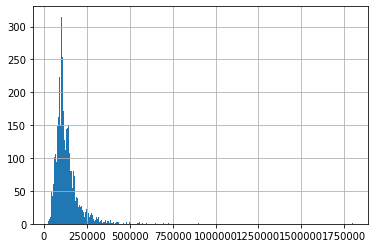

In [22]:
test[test["賃料"]!=0]["賃料"].hist(bins = 500)

In [23]:
aa

361

# ensemble

In [24]:
model = pd.read_csv('../output/exp0_+address_poisson_word_out2_people_num7+ekiuserate_kyori_NOmeta/exp0_+address_poisson_word_out2_people_num7+ekiuserate_kyori_NOmeta.csv', header=None)
model = model.set_index(0)
model.head(3)

,1
0,
31471,128829.064905
31472,118446.940764
31473,76697.127097


In [25]:
test[test["賃料"]!=0]["賃料"]
#test.shape

31471    111000.0
31481     51000.0
31484    101000.0
31487    547000.0
31502     50000.0
           ...   
62700     89000.0
62702    104000.0
62706     86000.0
62720    120000.0
62723    166000.0
Name: 賃料, Length: 5929, dtype: float64

In [26]:
try:
    test = test.set_index("id")
except:
    pass

In [27]:
ensemble = pd.DataFrame()
ensemble["id"] = model.index
ensemble["賃料"] = np.where(test["賃料"]!=0, test["賃料"], model[1])

In [28]:
sum(abs(ensemble["賃料"].values - model[1].values))
#ensemble["賃料"].values - model[1].values)

28918603.41252455

In [30]:
ensemble = ensemble.reset_index(drop=True)
ensemble.to_csv('ensemble_linear.csv', index=False, header=None)

In [31]:
ensemble[ensemble["賃料"] == ensemble["賃料"].max()]

,id,賃料
2823,34294,1800000.0


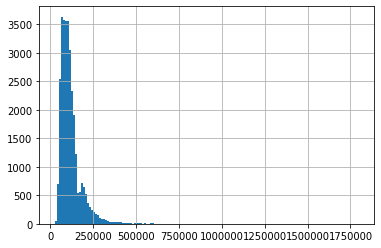

In [32]:
ensemble["賃料"].hist(bins=150)

In [33]:
train_model = pd.read_csv('../output/exp0_+address_poisson_word_out2_people_num7+ekiuserate_kyori_NOmeta/yoof_and_target.csv')

ridged = np.where(train["予測値"]>0, train["予測値"], train_model["exp0_+address_poisson_word_out2_people_num7+ekiuserate_kyori_NOmeta"])

In [34]:
train_model["exp0_+address_poisson_word_out2_people_num7+ekiuserate_kyori_NOmeta"] = ridged

In [36]:
train_model.columns = ['賃料', 'ensemble_linear']

In [37]:
train_model.to_csv("../output/vs_trains/ensemble_linear.csv", index=False)